In [146]:
import cdsapi
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon
import collections
import geopandas

In [ ]:
DATA_BOUNDARIES = [52.2, -6.8, 39.2, 11.2]

In [3]:
dataset = "seasonal-monthly-single-levels"
request = {
    "originating_centre": "ecmwf",
    "system": "51",
    "variable": [
        "2m_dewpoint_temperature",
        "2m_temperature",
        "total_precipitation"
    ],
    "year": ["2025"],
    "month": ["02"],
    "leadtime_month": [
        "1",
        "2",
        "3",
        "4",
        "5",
        "6"
    ],
    "data_format": "netcdf",
    "product_type": [
        "ensemble_mean",
        "hindcast_climate_mean",
        "monthly_maximum",
        "monthly_mean",
        "monthly_minimum",
        "monthly_standard_deviation"
    ],
    "area": DATA_BOUNDARIES
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-02-25 11:55:22,511 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-25 11:55:22,512 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-02-25 11:55:22,777 INFO Request ID is 78648146-c576-4ccb-9b39-caa206985c07
2025-02-25 11:55:22,958 INFO status has been updated to accepted
2025-02-25 11:55:31,379 INFO status has been updated to running
Recovering from connection error [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))], attemps 1 of 500
Retrying in 120 seconds
2025-02-25 11:58:58,060 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non

2f294919bc668198f360698f5c6d07ea.zip:   0%|          | 0.00/2.16M [00:00<?, ?B/s]

'2f294919bc668198f360698f5c6d07ea.zip'

In [140]:
ecmwf = Dataset("ecmwf/data_0.nc")
ecmwf.variables["t2m"]

<class 'netCDF4.Variable'>
float32 t2m(forecastMonth, latitude, longitude)
    _FillValue: nan
    GRIB_paramId: 167
    GRIB_dataType: em
    GRIB_numberOfPoints: 266
    GRIB_typeOfLevel: surface
    GRIB_stepUnits: 1
    GRIB_stepType: instant
    GRIB_gridType: regular_ll
    GRIB_uvRelativeToGrid: 0
    GRIB_NV: 0
    GRIB_Nx: 19
    GRIB_Ny: 14
    GRIB_cfName: unknown
    GRIB_cfVarName: t2m
    GRIB_gridDefinitionDescription: Latitude/Longitude Grid
    GRIB_iDirectionIncrementInDegrees: 1.0
    GRIB_iScansNegatively: 0
    GRIB_jDirectionIncrementInDegrees: 1.0
    GRIB_jPointsAreConsecutive: 0
    GRIB_jScansPositively: 0
    GRIB_latitudeOfFirstGridPointInDegrees: 52.2
    GRIB_latitudeOfLastGridPointInDegrees: 39.2
    GRIB_longitudeOfFirstGridPointInDegrees: -6.8
    GRIB_longitudeOfLastGridPointInDegrees: 11.2
    GRIB_missingValue: 3.4028234663852886e+38
    GRIB_name: 2 metre temperature
    GRIB_shortName: 2t
    GRIB_system: 51
    GRIB_totalNumber: 0
    GRIB_units: 

In [127]:
data = (ecmwf.variables["t2m"][:][0] - 273.15).round(1) #shape 10,14 -> latitude 10; longitude 14

In [49]:
lon_grid, lat_grid = np.meshgrid(ecmwf.variables["longitude"][:], ecmwf.variables["latitude"][:])

In [ ]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=38,  urcrnrlat=55, llcrnrlon=-6, urcrnrlon=10)
temperature_range = np.arange(np.min(data), np.max(data), 0.5)
contour = m.contourf(lon_grid, lat_grid, ecmwf.variables["t2m"][:][0] - 273,15, levels=temperature_range, cmap='coolwarm', alpha=0.7)

In [233]:
temp_dict = collections.defaultdict(list)
for temp_index, item in enumerate(contour.collections):
    current_polygon = []
    temp_polygons = []
    path = item.get_paths()[0]
    for vert, code in zip(path.vertices, path.codes):
        if code == mpath.Path.MOVETO: # Start a new polygon
            current_polygon = [tuple(vert)]
        elif code == mpath.Path.LINETO:
            current_polygon.append(tuple(vert))
        elif code == mpath.Path.CLOSEPOLY:
            current_polygon.append(current_polygon[0])  # Ensure closure by taking first tuple in array (in case of conversion error)
            temp_polygons.append(Polygon(current_polygon))
    
    temp_dict[float(temperature_range[temp_index])] = temp_polygons # Save the completed polygon

temp_dict

C:\Users\alexl\AppData\Local\Temp\ipykernel_14780\1247488719.py:2: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for temp_index, item in enumerate(contour.collections):


defaultdict(list,
            {-5.2: [<POLYGON ((8.2 46.286, 8.378 46.2, 8.2 46.149, 8.053 46.2, 8.2 46.286))>],
             -4.7: [<POLYGON ((8.2 46.425, 8.663 46.2, 8.2 46.066, 7.818 46.2, 8.2 46.425))>,
              <POLYGON ((8.053 46.2, 8.2 46.149, 8.378 46.2, 8.2 46.286, 8.053 46.2))>],
             -4.2: [<POLYGON ((10.2 47.253, 10.2 47.2, 10.2 46.2, 10.2 46.142, 9.724 46.2, 10.05...>,
              <POLYGON ((8.2 46.563, 8.948 46.2, 8.2 45.984, 7.583 46.2, 8.2 46.563))>,
              <POLYGON ((7.818 46.2, 8.2 46.066, 8.663 46.2, 8.2 46.425, 7.818 46.2))>,
              <POLYGON ((7.2 45.439, 7.251 45.2, 7.2 45.151, 7.025 45.2, 7.2 45.439))>],
             -3.7: [<POLYGON ((10.2 47.387, 10.2 47.253, 10.055 47.2, 9.724 46.2, 10.2 46.142, 1...>,
              <POLYGON ((7.583 46.2, 8.2 45.984, 8.948 46.2, 8.2 46.563, 7.583 46.2))>,
              <POLYGON ((7.2 45.906, 7.351 45.2, 7.2 45.055, 6.683 45.2, 7.2 45.906))>,
              <POLYGON ((7.025 45.2, 7.2 45.151, 7.251 45.2

In [234]:
geo = geopandas.read_file("geojsonfrance_corse_20.json") #get polygon values for each french dep
geo["code"] = geo["code"].astype(int)
geo = geo.sort_values(by="code").reset_index(drop=True)

In [248]:
area = []
for k, v in temp_dict.items():
    for poly in v:
        if geo["geometry"].iloc[84].intersects(poly):
            print(k, poly)
            area.append((geo["geometry"].iloc[84].intersection(poly).area/geo["geometry"].iloc[84].area)*100)
            break
sum(area)

5.3 POLYGON ((-3.8000000000000003 51.30930099857348, -3.5610106051154085 51.2, -2.8 50.90555153270577, -1.7999999999999998 50.88292740046839, -0.7999999999999998 50.773765911207704, 0.2000000000000002 50.73380919220056, 0.7767870579382998 50.2, 0.2000000000000002 49.66969906606711, -0.5169482576557547 49.20000000000001, -0.7999999999999998 48.946284902981546, -1.6299473684210521 48.2, -0.8201619433198376 47.2, -0.7999999999999998 47.18137621540763, 0.2000000000000002 46.219578783151334, 0.2165567282321904 46.2, 0.8684637404580157 45.2, 1.2000000000000002 44.7508080155139, 1.4557322929171672 44.2, 1.2000000000000002 43.946096543504176, 0.2000000000000002 43.85109099350046, -0.7749391727493914 43.2, -0.7999999999999998 43.173743627093955, -1.7999999999999998 42.58731559155337, -2.8 42.65506685821638, -3.8 42.66715752499324, -4.8 42.76365648517043, -5.8 42.81695895522388, -6.8 42.59224195710456, -6.8 42.76382372654156, -5.8 43.00800373134329, -4.8 42.914755791648226, -3.8 42.8054985139151

100.00000000000034

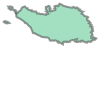

In [247]:
geo["geometry"].iloc[84]

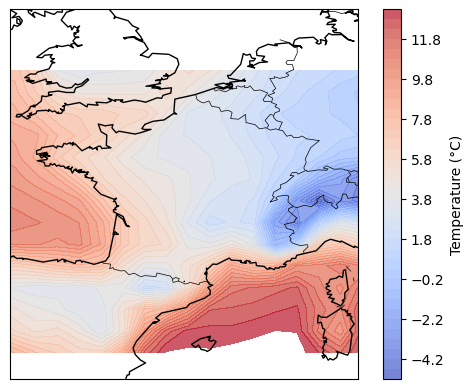

In [144]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=38,  urcrnrlat=55, llcrnrlon=-6, urcrnrlon=10)
m.drawcoastlines()
m.drawcountries()
temperature_range = np.arange(np.min(data), np.max(data), 0.5)
contour = m.contourf(lon_grid, lat_grid, ecmwf.variables["t2m"][:][0] - 273,15, levels=temperature_range, cmap='coolwarm', alpha=0.7)
cbar = plt.colorbar(contour, orientation='vertical', label="Temperature (°C)")